## oil gas drilling rig forecast model
Using data from EIA and quandl

In [16]:
# %load og_forecast_xk.py
"""
Created on Tue Sep 19 18:55:23 2017

@author: XK
"""
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
import operator
%matplotlib inline
QUANDL_TOKEN = None
EIA_API = None

# os.getcwd()

### This figure is to show what we are modeling
The production of oil and gas requires drilling lot of oil and gas wells in different regions of the US. The rig referes to a special machine to drill well to underground. The rig are scattered across US. There is public data of active rig each week from Baker Hughes and quandl. The number reflects the oil and gas industry activity.

(301, 575)


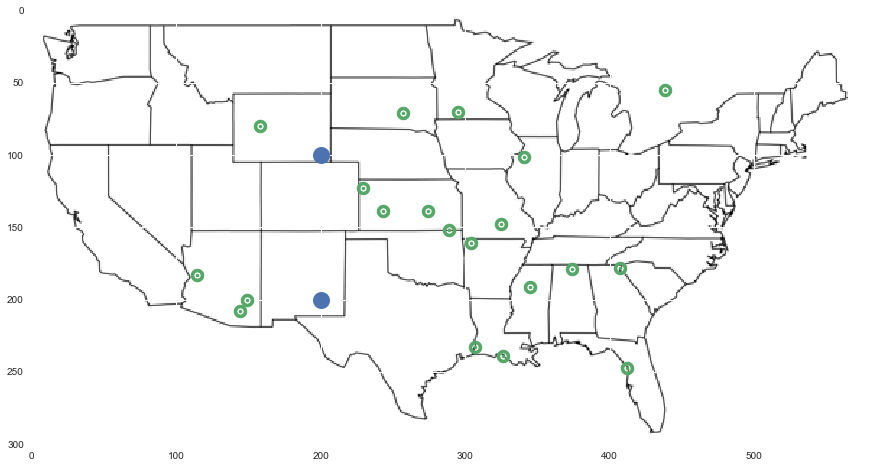

In [2]:
im = plt.imread('fig/us2.png')
rigs = np.c_[np.random.randint(111, 450, size=20),
             np.random.randint(51, 250, size=20)]
print(im.shape)
plt.figure(figsize = (20,8))
plt.imshow(im,cmap='gray')
plt.scatter([200,200],[100,200],marker='o',linewidths=10,zorder=1)
plt.scatter(rigs[:, 0], rigs[:, 1],marker='.',linewidths=10,zorder=1)
plt.show()

imported to another module


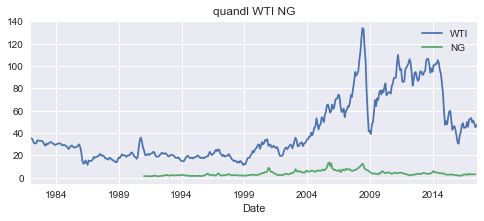

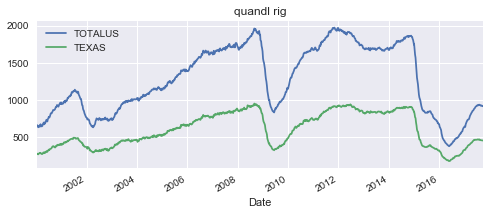

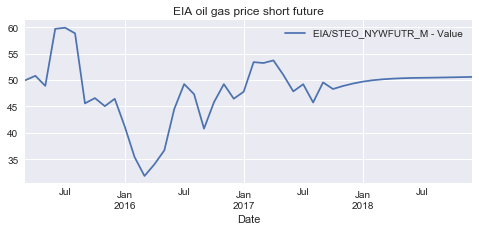

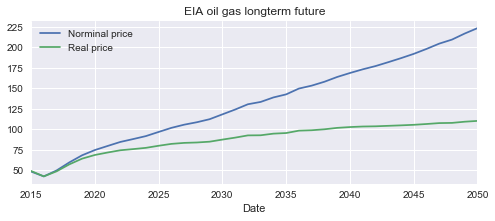

In [4]:
#%% get raw data using quandl API and website
# https://www.quandl.com/data/BKRHUGHES-Baker-Hughes-Investor-Relations?page=4
def fetch_data():
    import quandl
    quandl_code = ["COM/WLD_CRUDE_WTI", 'COM/PNGASUS_USD']
    og_price = quandl.get(quandl_code, authtoken=QUANDL_TOKEN)
    og_price.columns = ['WTI','NG']
    og_price.plot(title='quandl WTI NG', figsize=(8,3))
    quandl_code_rig = ['BKRHUGHES/RIGS_BY_STATE_TOTALUS_LAND', 
                       'BKRHUGHES/RIGS_BY_STATE_TEXAS_LAND']
    og_rig = quandl.get(quandl_code_rig,
                        authtoken=QUANDL_TOKEN)
    og_rig.columns = [s.split('_')[-2] for s in og_rig.columns]
    og_rig.plot(title='quandl rig', figsize=(8,3))
    quandl_code_future = ['EIA/STEO_NYWFUTR_M']
    (quandl.get(quandl_code_future,
               authtoken=QUANDL_TOKEN)
             .plot(figsize=(8,3),
                   title='EIA oil gas price short future'))
    
    # https://www.eia.gov/opendata/qb.php?sdid=AEO.2017.REF2017.PRCE_NOMP_TEN_NA_WTI_NA_USA_NDLRPBRL.A
    from EIAgov import EIAgov
    eia_future = ['AEO.2017.REF2017.PRCE_NOMP_TEN_NA_WTI_NA_USA_NDLRPBRL.A',
                  'AEO.2017.REF2017.PRCE_RLP_TEN_NA_WTI_NA_USA_Y13DLRPBBL.A'] # STEO.NYWSTEO.M
    eia = EIAgov(EIA_API, eia_future)
    og_future = eia.GetData().set_index('Date').sort_index()
    og_future.plot(title='EIA oil gas longterm future', figsize=(8,3))
    plt.legend(['Norminal price', 'Real price'])
    plt.show()
    return og_price, og_rig

#og_price, og_rig = fetch_data()

if __name__ == '__main__':
    og_price, og_rig = fetch_data()

### preprocessing data. 
There is correlated trend between oil and rig number. However, there might be a lag between the oil gas price and rig count. 

In [14]:
df = pd.merge(og_price.resample('d').ffill(),
                     og_rig.resample('d').ffill(),
                     left_index=True, 
                     right_index=True,
                     how='inner')
df = df.loc['2009':].dropna(axis=0).resample('w').mean()
# plt.xcorr(df.WTI, df.NG, maxlags=4);
df.head()

,WTI,NG,TOTALUS,TEXAS
Date,,,,
2009-01-04,41.439048,5.840000,1579.500000,753.250000
2009-01-11,41.439048,5.840000,1539.571429,725.857143
2009-01-18,41.439048,5.840000,1510.428571,701.428571
2009-01-25,41.439048,5.840000,1478.000000,687.142857
2009-02-01,41.524605,5.665714,1433.714286,669.000000


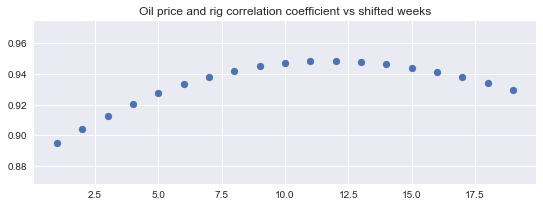

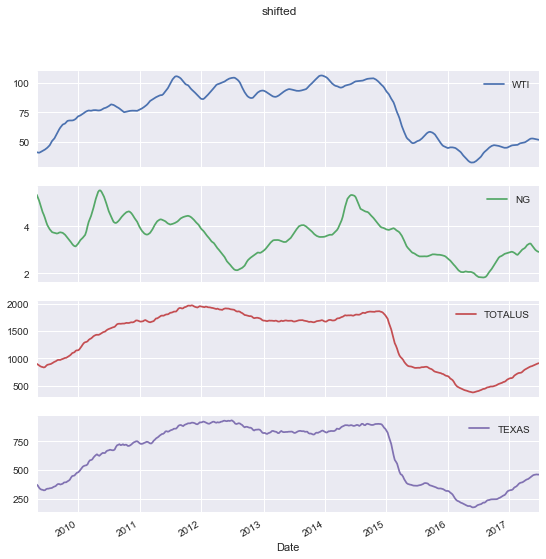

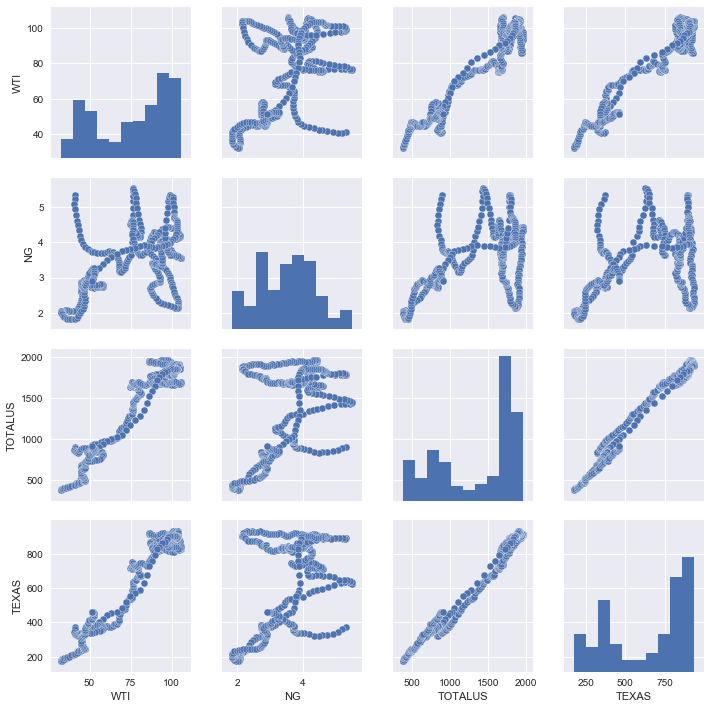

In [9]:
def preprocess(og_price, og_rig):
    df = pd.merge(og_price.resample('d').ffill(),
                     og_rig.resample('d').ffill(),
                     left_index=True, 
                     right_index=True,
                     how='inner')
    df = df.loc['2009':].dropna(axis=0).resample('w').mean()
    # df.plot(subplots=4, figsize=(9, 9), title='raw')
    
    corr = []
    for i in range(1, 20):
    #    og_price_shift = df.WTI.shift(periods=i, freq='w')
        corr.append([i, np.corrcoef(df.WTI[:-i],
                             df.TOTALUS[i:])[0, 1]])
    corr = np.array(corr)
    plt.figure(figsize=(9, 3))
    plt.scatter(corr[:, 0], corr[:, 1])
    plt.title('Oil price and rig correlation coefficient vs shifted weeks')
    plt.grid(True)
    plt.show()
    lag = corr[:, 1].argmax() + 1
    df_shift = pd.merge(df[['WTI', 'NG']].shift(lag),
                        df.iloc[:, 2:],
                        left_index=True, 
                        right_index=True,
                        how='inner').dropna(axis=0)
    df_shift['WTI'] = df_shift.WTI.rolling(11, center=True).mean()
    df_shift['NG'] = df_shift.NG.rolling(11, center=True).mean()
    df_shift.dropna(axis=0, inplace=True)
    df_shift.plot(subplots=4, figsize=(9, 9), title='shifted')
    plt.show()
    sns.pairplot(df_shift)
    # sns.heatmap(df_shift)
    plt.show()
    return df_shift

df_shift = preprocess(og_price, og_rig)

## Linear regression model

clf train score 0.926
clf test  score 0.944
r2_score 0.944


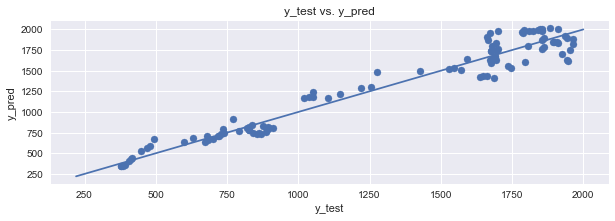

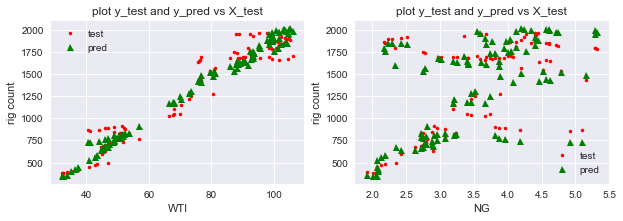

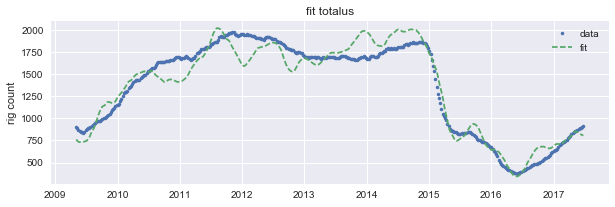

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
def model(df_shift):
    X, y = df_shift.iloc[:, :2].values, df_shift.iloc[:, 2].values
    
    clf = LinearRegression(normalize=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('clf train score {:.3f}'.format(clf.score(X_train, y_train)))
    print('clf test  score {:.3f}'.format(clf.score(X_test, y_test)))
    print('r2_score {:.3f}'.format(r2_score(y_test, y_pred)))
    plt.figure(figsize=(10, 3))
    plt.scatter(y_test, y_pred)
    plt.plot([220, 2000], [220, 2000])
    plt.title('y_test vs. y_pred')
    # plt.legend()
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()
    _, ax = plt.subplots(1, 2, figsize=(10, 3))
    for i in range(2):
        ax[i].plot(X_test[:, i], y_test, 'r.', X_test[:, i], y_pred, 'g^')
        ax[i].set_title('plot y_test and y_pred vs X_test')
        ax[i].set_xlabel(df_shift.columns[i])
        ax[i].set_ylabel('rig count')
        ax[i].legend(['test','pred'])
    plt.show()
    plt.figure(figsize=(10, 3))
    for col in df_shift.columns[2:3]:
        plt.plot(df_shift.index, df_shift[col].values, '.',
                 df_shift.index, clf.predict(df_shift.iloc[:, :2].values), '--')
        plt.ylabel('rig count')
        plt.title('fit ' + col.lower())
    plt.legend(['data', 'fit'])
    plt.show()

    return clf

clf = model(df_shift)

In [6]:
print('intercept {:.2f}, coef WTI {:.2f}, NG {:.2f}'.format(clf.intercept_, *clf.coef_))

intercept -478.10, coef WTI 20.87, NG 71.31


## polynomial and ridge shrinkage

degree 2 score 0.945
coef  [0.0, 42.84, 73.07, -0.1, -2.13, 19.15]
degree 3 score 0.963
coef  [0.0, -85.82, 58.35, 2.12, -17.57, 216.12, -0.01, 0.02, 1.63, -31.0]


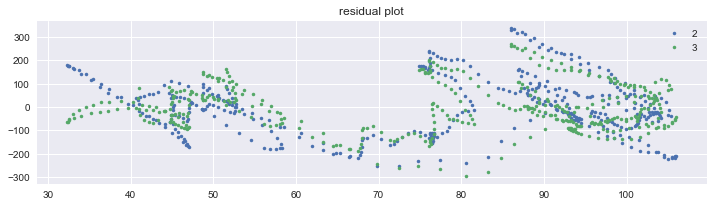

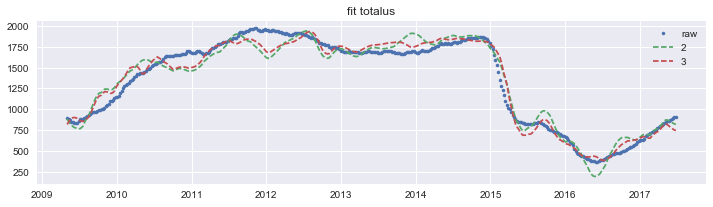

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
FIG_SIZE = (12, 3)
def model_poly(df_shift):
    X, y = df_shift.iloc[:, :2].values, df_shift.iloc[:, 2].values
    pipes = []
    plt.figure(figsize=FIG_SIZE)
    for count, degree in enumerate([2, 3]):
        pipe = make_pipeline(PolynomialFeatures(degree), Ridge(normalize=False))
        pipe.fit(X, y)
        
        X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
        clf = Ridge()
        clf.fit(X_poly, y)
        print('degree {} score {:.3f}'.format(degree, clf.score(X_poly, y)))
        print('coef ', list(float("{0:0.2f}".format(i)) for i in clf.coef_))
       
        plt.plot(X[:, 0], y - pipe.predict(X), '.')
        pipes.append(pipe)
    plt.title('residual plot')
    plt.legend([2, 3, 4])
    plt.show()
    
    plt.figure(figsize=FIG_SIZE)
    plt.plot(df_shift.index, df_shift.iloc[:, 2].values, '.')
    for i, pipe in enumerate(pipes):
        for col in df_shift.columns[2:3]:
            plt.plot(df_shift.index,
                     pipe.predict(df_shift.iloc[:, :2].values), '--')
            plt.title('fit ' + col.lower())
        plt.legend(['raw', 2, 3, 4])
    plt.show()
    return pipes
pipes = model_poly(df_shift)

### residual plot of regression model shows there is not apparent trends or distribution in model
ploting model to observation value also confirmed the model good performance

In [8]:
for pipe in pipes:
    print('R2 score ', pipe.score(df_shift.values[:, :2], df_shift.values[:, 2]))

R2 score  0.944945387411
R2 score  0.962974228416


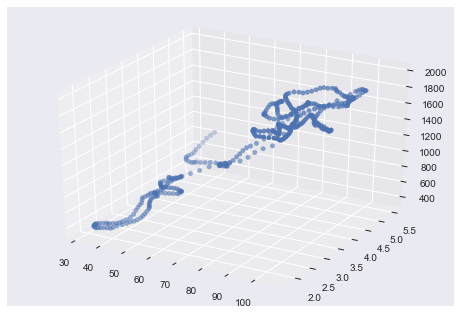

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_shift.values[:, 0], df_shift.values[:, 1], df_shift.values[:, 2], marker='o');

## Conclusion
Comparing polynomial regression model shows the improvement is small by increasing model compolexity, so linear model with order 1 is good for predict rig number based on oil and natual gas price.